**Phishing Email Detection Model v2.4 - 27th October 2024**

**Step 1: Install the necessary packages**

In [ ]:
#installing the transformers and datasets packages
!pip install datasets
!pip install transformers
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.5 MB/s eta 0:00:00


In [ ]:
#import the pipeline of transformers
from transformers import pipeline
#import AutoTokenizer for tokenization purposes
from transformers import AutoTokenizer
#import the Trainer API
from transformers import TrainingArguments, Trainer
#import early stopping callback
from transformers import EarlyStoppingCallback, IntervalStrategy



#import torch
import torch
#import Data loader from torch
from torch.utils.data import DataLoader
#import tqdm for a progress bar
from tqdm.auto import tqdm

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
from tqdm import tqdm
import numpy as np

In [ ]:
from sklearn.metrics import classification_report

**Step 2 - Import Dataset from Hugging Face**

In [ ]:
from datasets import load_dataset

train_dataset = load_dataset("cybersectony/PhishingEmailDetectionv2.0", split="train")
evaluation_dataset = load_dataset("cybersectony/PhishingEmailDetectionv2.0", split="validation")
test_dataset  = load_dataset("cybersectony/PhishingEmailDetectionv2.0", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/534 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/27.9M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/3.17M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/9.21M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

In [ ]:
import datasets

#combine the train and test dataset into one datset
main_dataset= datasets.DatasetDict({
    'train': train_dataset,
    'test': test_dataset,
    'evaluate': evaluation_dataset
})

In [ ]:
#preview of the dataset after merging
main_dataset

DatasetDict({
    train: Dataset({
        features: ['content', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['content', 'label'],
        num_rows: 60000
    })
    evaluate: Dataset({
        features: ['content', 'label'],
        num_rows: 20000
    })
})

In [ ]:
# training and testing data size
training_data_size = main_dataset['train'].num_rows
testing_data_size = main_dataset['test'].num_rows
evaluation_data_size = main_dataset['evaluate'].num_rows

**Step 3 - Tokenizing Dataset**

In [ ]:
#import AutoTokenizer for tokenization purposes
from transformers import AutoTokenizer

#loading a tokenizer from the pretrained model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Have a tokenizer function that uses the tokenizer
def tokenize_function(data):
    return tokenizer(data["content"], padding="max_length", truncation=True)

In [ ]:
# Tokenize all the data using the mapping functionality
tokenized_datasets = main_dataset.map(tokenize_function)

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

**Step 4: Prepare the tokenized Dataset**

In [ ]:
#changing the format of the tokenized dataset to torch
tokenized_datasets.set_format("torch")

In [ ]:
#remove the content column as it is no longer needed
tokenized_datasets = tokenized_datasets.remove_columns(["content"])

In [ ]:
#shuffeling and selecting the needed size of dataset for training and evaluating the model
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(training_data_size))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(testing_data_size))
small_eval_dataset = tokenized_datasets["evaluate"].shuffle(seed=42).select(range(evaluation_data_size))

In [ ]:
# preview of the shuffeled and selected evaluation dataset
small_eval_dataset

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 20000
})

In [ ]:
# preview of the shuffeled and selected training dataset
small_train_dataset

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 120000
})

In [ ]:
# preview of the shuffeled and selected testing dataset
small_test_dataset

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 60000
})

In [ ]:
#load the dataset using DataLoader
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=4)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=4)
test_dataloader = DataLoader(small_test_dataset, batch_size=4)

**Step 5: Fine-tune the model**

In [ ]:
# Install huggingface_hub package to interact with huggingface platform
!pip install huggingface_hub

from huggingface_hub import notebook_login

In [ ]:
#login to huggingface
notebook_login()

In [ ]:
# Load model directly
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=4)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import evaluate
import numpy as np

precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric= evaluate.load("f1")
accuracy_metric = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):

    logits, labels = eval_pred # eval_pred is the tuple of predictions and labels returned by the model
    predictions = np.argmax(logits, axis=-1)
    precision = precision_metric.compute(predictions=predictions, references=labels, average='weighted')["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels, average='weighted')["recall"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')["f1"]
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    # The trainer is expecting a dictionary where the keys are the metrics names and the values are the scores.
    return {"precision": precision, "recall": recall, "f1-score": f1, 'accuracy': accuracy}

In [ ]:
from transformers import TrainingArguments
training_args = TrainingArguments(output_dir="test_trainer")

In [ ]:
training_args = TrainingArguments(
   f"training_with_callbacks",
   evaluation_strategy = IntervalStrategy.STEPS, # "steps"
   warmup_steps=500,                # number of warmup steps for learning rate
   save_steps=2000,
   eval_steps = 2000, # Evaluation and Save happens every 50 steps
   save_total_limit = 3, # Only last 5 models are saved. Older ones are deleted.
   learning_rate=1e-5,
   per_device_train_batch_size=4,
   per_device_eval_batch_size=4,
   num_train_epochs=5,
   weight_decay=0.01,
   push_to_hub=False,
   load_best_model_at_end=True)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=10)],
)

In [ ]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Precision,Recall,F1-score,Accuracy
2000,0.057300,0.060195,0.988676,0.988450,0.988441,0.988450
4000,0.044700,0.050877,0.990118,0.989900,0.989899,0.989900
6000,0.038600,0.044573,0.992988,0.992700,0.992689,0.992700
8000,0.060100,0.033994,0.993630,0.993500,0.993496,0.993500
10000,0.028700,0.043608,0.992626,0.992500,0.992493,0.992500
12000,0.025900,0.030919,0.994924,0.994900,0.994899,0.994900
14000,0.045800,0.045543,0.992020,0.991900,0.991901,0.991900
16000,0.021500,0.037565,0.993746,0.993600,0.993591,0.993600
18000,0.043800,0.034197,0.994249,0.994200,0.994189,0.994200
20000,0.029800,0.031568,0.994668,0.994600,0.994597,0.994600


TrainOutput(global_step=84000, training_loss=0.027226475370781763, metrics={'train_runtime': 17616.9139, 'train_samples_per_second': 34.058, 'train_steps_per_second': 8.515, 'total_flos': 4.4510633459712e+16, 'train_loss': 0.027226475370781763, 'epoch': 2.8})

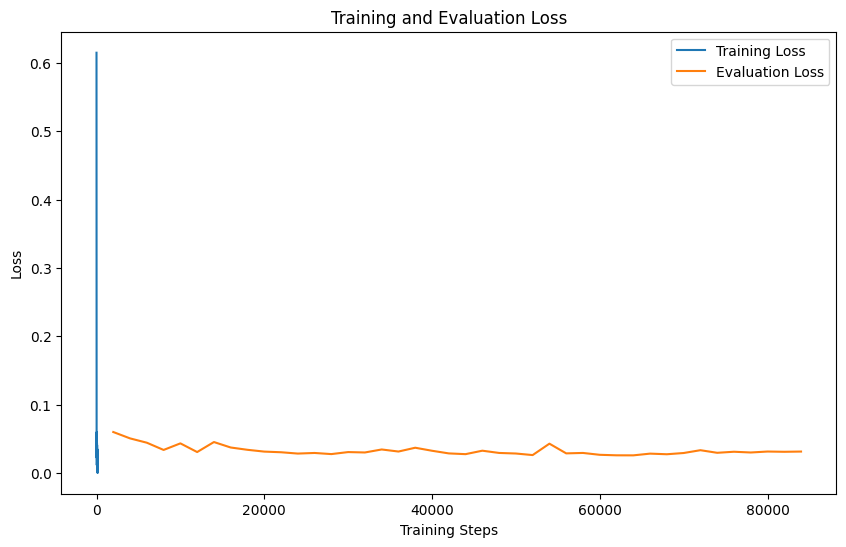

In [ ]:
import matplotlib.pyplot as plt

# Extract the logged values
train_loss = [x['loss'] for x in trainer.state.log_history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in trainer.state.log_history if 'eval_loss' in x]
train_steps = range(len(train_loss))
eval_steps = [x['step'] for x in trainer.state.log_history if 'eval_loss' in x]

# Plot training and evaluation loss
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss, label='Training Loss')
plt.plot(eval_steps, eval_loss, label='Evaluation Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.show()

Getting predictions: 100%|██████████| 15000/15000 [08:49<00:00, 28.31it/s]


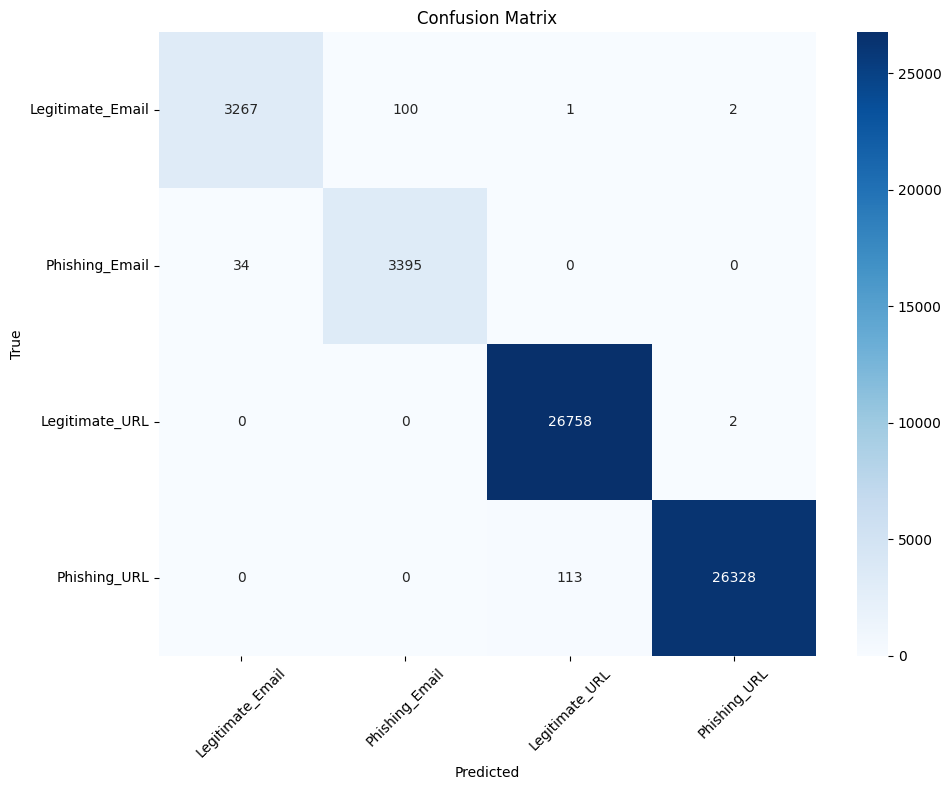

In [ ]:
def get_predictions(trainer, dataloader):
    """Get predictions from the model using the provided dataloader."""
    predictions = []
    true_labels = []

    # Set model to evaluation mode
    trainer.model.eval()

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Getting predictions"):
            # Get predictions for current batch
            outputs = trainer.model(**{k: v.to(trainer.model.device) for k, v in batch.items() if k != 'label'})
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            # Move predictions and labels to CPU
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch['label'].cpu().numpy())

    return np.array(predictions), np.array(true_labels)

def plot_confusion_matrix(predictions, true_labels, class_names=None):
    """Plot confusion matrix using seaborn."""
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names if class_names else "auto",
        yticklabels=class_names if class_names else "auto"
    )

    # Set labels and title
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    # Rotate x-axis labels
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    return cm

# Get predictions and true labels
predictions, true_labels = get_predictions(trainer, test_dataloader)

# If you have class names, create a list
class_names = ['Legitimate_Email', 'Phishing_Email', 'Legitimate_URL', 'Phishing_URL']

# Plot confusion matrix
cm = plot_confusion_matrix(predictions, true_labels, class_names)

In [ ]:
# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))

**Step 6: Evaluate the Model**

In [ ]:
trainer.evaluate(small_test_dataset)

{'eval_loss': 0.026328833773732185,
 'eval_precision': 0.9958272716983122,
 'eval_recall': 0.9958,
 'eval_f1-score': 0.995798840443335,
 'eval_accuracy': 0.9958,
 'eval_runtime': 531.3444,
 'eval_samples_per_second': 112.921,
 'eval_steps_per_second': 28.23,
 'epoch': 2.8}

**Step 7: Push the model to the Hugging Face Hub**

In [ ]:
#specify the path for the trained model and tokenizer to huggingface repository
model.save_pretrained("path/to/phishing-email-detection-distilbert_v2.4.1")
tokenizer.save_pretrained("path/to/phishing-email-detection-distilbert_v2.4.1")

('path/to/phishing-email-detection-distilbert_v2.4.1/tokenizer_config.json',
 'path/to/phishing-email-detection-distilbert_v2.4.1/special_tokens_map.json',
 'path/to/phishing-email-detection-distilbert_v2.4.1/vocab.txt',
 'path/to/phishing-email-detection-distilbert_v2.4.1/added_tokens.json',
 'path/to/phishing-email-detection-distilbert_v2.4.1/tokenizer.json')

In [ ]:
model.push_to_hub("phishing-email-detection-distilbert_v2.4.1")

README.md:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/cybersectony/phishing-email-detection-distilbert_v2.4.1/commit/79f8fd53ee5830be098a4b6068f755b52bb58561', commit_message='Upload DistilBertForSequenceClassification', commit_description='', oid='79f8fd53ee5830be098a4b6068f755b52bb58561', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
tokenizer.push_to_hub("phishing-email-detection-distilbert_v2.4.1")

CommitInfo(commit_url='https://huggingface.co/cybersectony/phishing-email-detection-distilbert_v2.4.1/commit/9df9c012736df12d59ebb1b87dc08291722ad324', commit_message='Upload tokenizer', commit_description='', oid='9df9c012736df12d59ebb1b87dc08291722ad324', pr_url=None, pr_revision=None, pr_num=None)